In [1]:
import torch
from test_dense import *
import json

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# sparse 
ss = [0.2, 0.4, 0.6, 0.8]
rr = []

channels, group = regnet_parameters("008")
for i, width in enumerate(widths):
    channel = channels[i]
    bs = TVMDynamicBlockEvaluator(channel, width, group, f"log_dense/c{channel}_w{width}_g{group}")

    # dense
    bs.setup()
    # DO NOT AUTOTUNE
    bs.build()
    res_dense = bs.evaluate(verbose=True)

    factors = get_factors(width)
    for g in factors:
        for s in ss:
            sl = int(s * ((width // g) ** 2))
            # sl = (sl // 8) * 8  # better for scheduling
            if sl == 0:
                continue
            
            bs.setup_sparse(sl, g, True, True, True)
            # DO NOT AUTOTUNE
            bs.build("sparse")
            res = bs.evaluate("sparse", True)
            res["conv1"] = res_dense["conv1"]
            res["maskconv1"] = res_dense["maskconv1"]
            res["channel"] = channel
            res["width"] = width
            res["group"] = group
            res["sparsity"] = s
            res["granularity"] = g
            print(res)
            rr.append(res)


{'conv2': 6.0108999999999995e-06, 'conv3': 5.5039e-06, 'gather': 6.39624e-06, 'scatter_add': 3.67699e-06, 'maskconv2': 2.5345e-06, 'conv1': 8.05035e-06, 'maskconv1': 1.0987600000000001e-05, 'channel': 64, 'width': 56, 'group': 16, 'sparsity': 0.2, 'granularity': 1}
{'conv2': 7.64831e-06, 'conv3': 7.231739999999999e-06, 'gather': 9.59234e-06, 'scatter_add': 4.19503e-06, 'maskconv2': 2.60266e-06, 'conv1': 8.05035e-06, 'maskconv1': 1.0987600000000001e-05, 'channel': 64, 'width': 56, 'group': 16, 'sparsity': 0.4, 'granularity': 1}
{'conv2': 1.032451e-05, 'conv3': 8.62451e-06, 'gather': 1.2916220000000002e-05, 'scatter_add': 4.16944e-06, 'maskconv2': 2.33685e-06, 'conv1': 8.05035e-06, 'maskconv1': 1.0987600000000001e-05, 'channel': 64, 'width': 56, 'group': 16, 'sparsity': 0.6, 'granularity': 1}
{'conv2': 1.250196e-05, 'conv3': 9.70944e-06, 'gather': 1.661976e-05, 'scatter_add': 4.93615e-06, 'maskconv2': 2.34104e-06, 'conv1': 8.05035e-06, 'maskconv1': 1.0987600000000001e-05, 'channel': 64, 

In [3]:
# store rr
with open("sparseperf.json", "w") as f:
    for r in rr:
        f.write(json.dumps(r)+"\n")

In [4]:
# restore rr quickly
rr = []
with open("sparseperf.json", "r") as f:
    for l in f.readlines():
        rr.append(json.loads(l))
print(rr)

[{'conv2': 4.85678e-06, 'conv3': 4.690039999999999e-06, 'gather': 5.8864300000000005e-06, 'scatter_add': 3.40202e-06, 'maskconv2': 2.42811e-06, 'conv1': 8.418959999999999e-06, 'maskconv1': 1.125724e-05, 'channel': 64, 'width': 56, 'group': 16, 'sparsity': 0.2, 'granularity': 1}, {'conv2': 7.436859999999999e-06, 'conv3': 6.83597e-06, 'gather': 9.40269e-06, 'scatter_add': 3.8138000000000002e-06, 'maskconv2': 2.46127e-06, 'conv1': 8.418959999999999e-06, 'maskconv1': 1.125724e-05, 'channel': 64, 'width': 56, 'group': 16, 'sparsity': 0.4, 'granularity': 1}, {'conv2': 8.918709999999999e-06, 'conv3': 8.5347e-06, 'gather': 1.27571e-05, 'scatter_add': 4.19992e-06, 'maskconv2': 2.57966e-06, 'conv1': 8.418959999999999e-06, 'maskconv1': 1.125724e-05, 'channel': 64, 'width': 56, 'group': 16, 'sparsity': 0.6, 'granularity': 1}, {'conv2': 1.2209319999999998e-05, 'conv3': 1.224127e-05, 'gather': 2.225757e-05, 'scatter_add': 4.7014e-06, 'maskconv2': 2.28849e-06, 'conv1': 8.418959999999999e-06, 'maskcon

In [4]:
import pandas as pd
rrr = []
with open("sparseperf.json", "r") as f:
    for l in f.readlines():
        rrr.append(json.loads(l))

df = pd.DataFrame(columns=["channel", "width", "group", "sparsity", "granularity", "conv1", "conv2", "conv3", "maskconv1", "maskconv2", "gather", "scatter_add"])
for r in rrr:
    for k in ["conv1", "conv2", "conv3", "maskconv1", "maskconv2", "gather", "scatter_add"]:
        r[k] *= 1000 # in ms, change content in rrr
    df = df.append(r, ignore_index=True)
print(df)
df.to_csv("sparseperf.csv")

/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

   channel width group sparsity granularity     conv1     conv2     conv3  \
0     64.0  56.0  16.0      0.2         1.0   0.00805  0.006011  0.005504   
1     64.0  56.0  16.0      0.4         1.0   0.00805  0.007648  0.007232   
2     64.0  56.0  16.0      0.6         1.0   0.00805  0.010325  0.008625   
3     64.0  56.0  16.0      0.8         1.0   0.00805  0.012502  0.009709   
4     64.0  56.0  16.0      0.2         2.0   0.00805  0.004772  0.004127   
..     ...   ...   ...      ...         ...       ...       ...       ...   
56   288.0  14.0  16.0      0.8         7.0  0.014557  0.010783  0.013175   
57   672.0   7.0  16.0      0.2         1.0  0.037368  0.015819  0.012586   
58   672.0   7.0  16.0      0.4         1.0  0.037368  0.019103  0.016546   
59   672.0   7.0  16.0      0.6         1.0  0.037368  0.022678  0.020828   
60   672.0   7.0  16.0      0.8         1.0  0.037368   0.03584    0.0216   

   maskconv1 maskconv2    gather scatter_add  
0   0.010988  0.002534  0.00

/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
/tmp/ipykernel_17011/1684560896.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

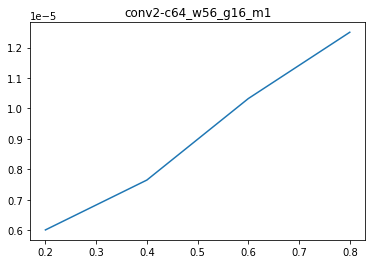

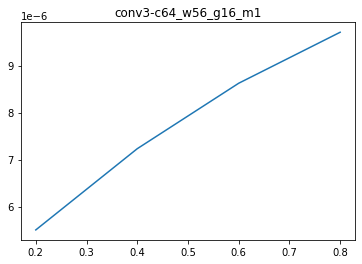

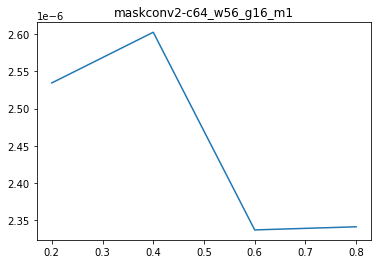

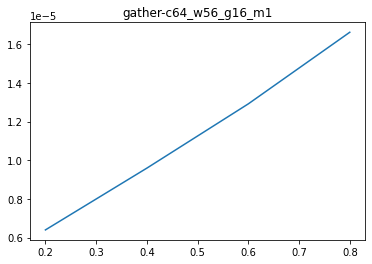

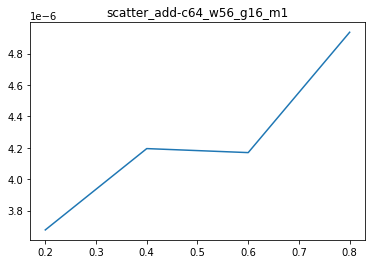

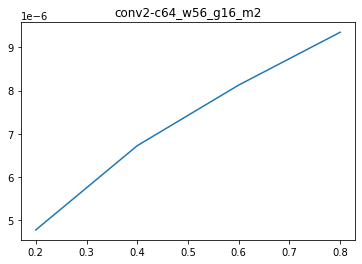

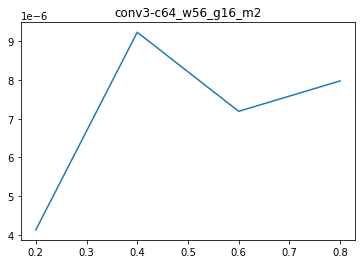

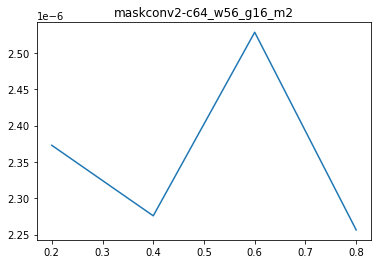

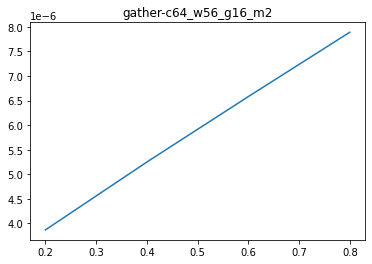

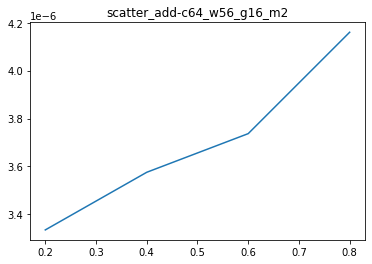

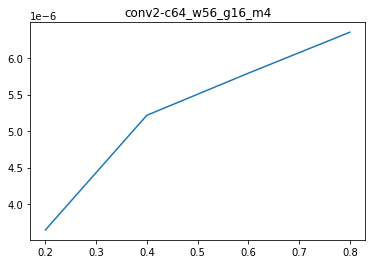

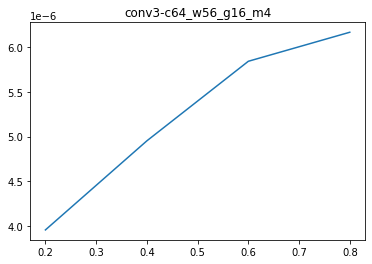

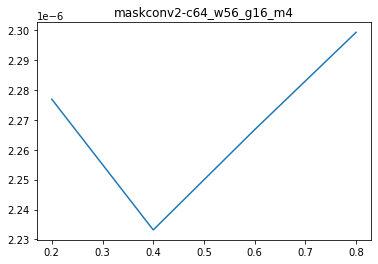

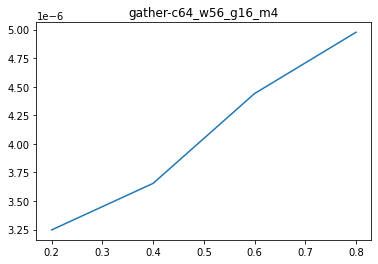

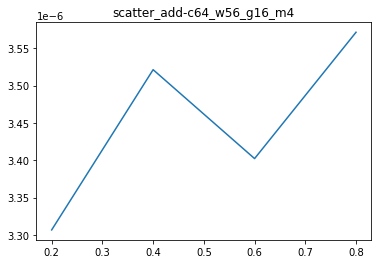

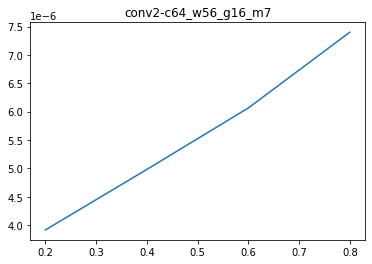

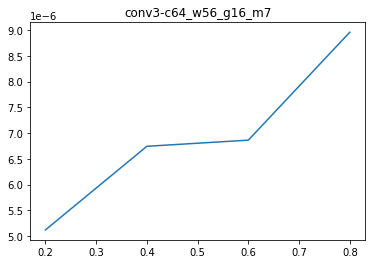

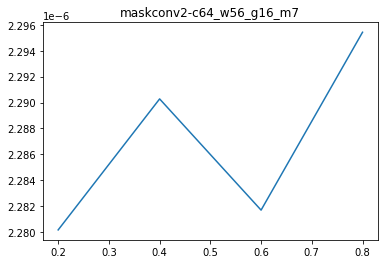

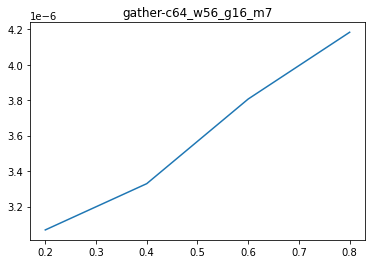

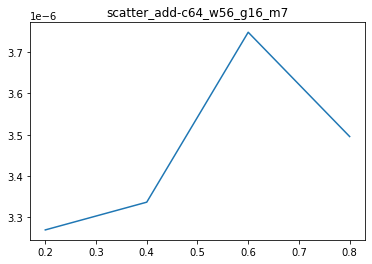

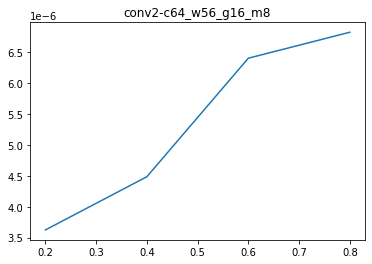

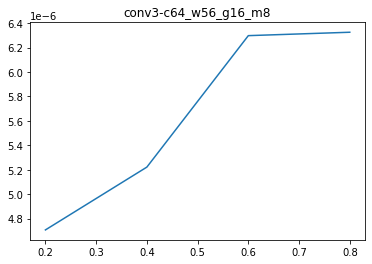

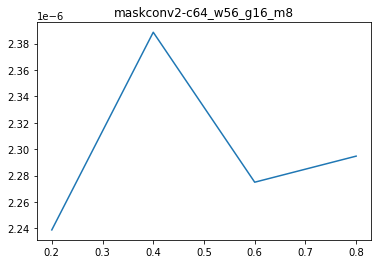

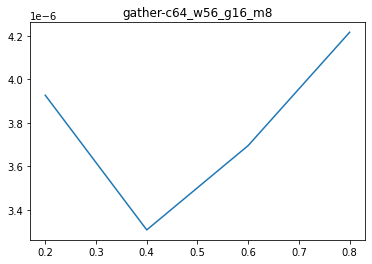

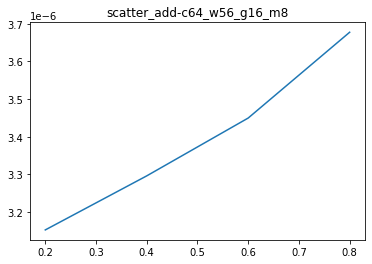

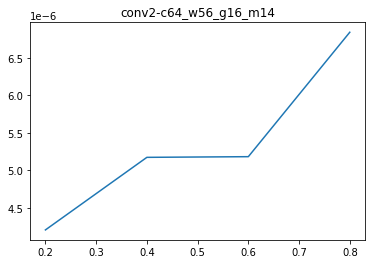

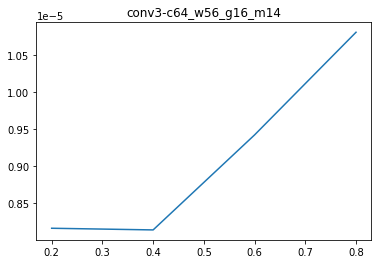

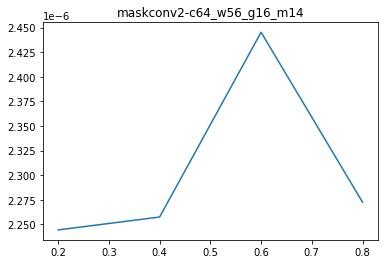

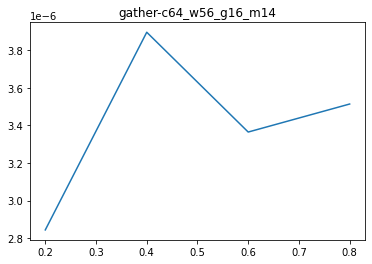

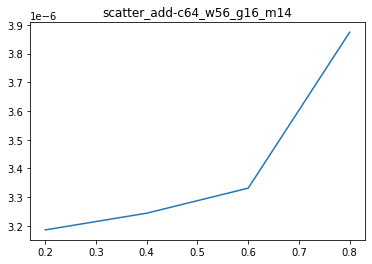

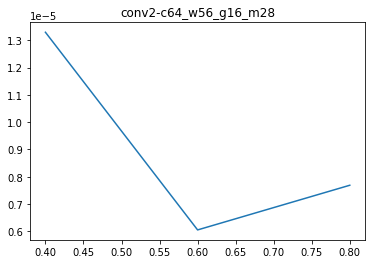

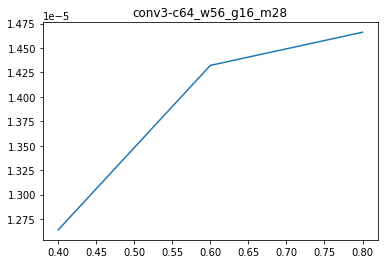

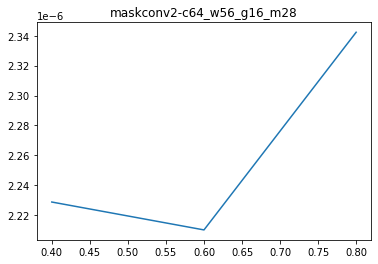

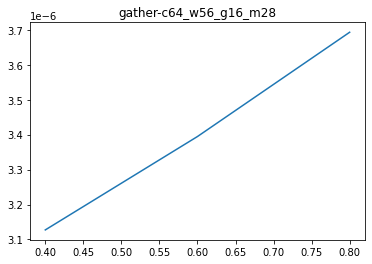

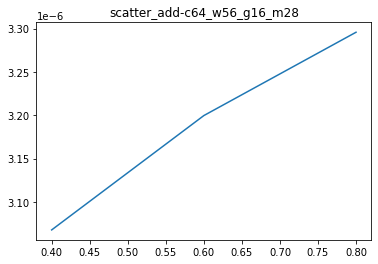

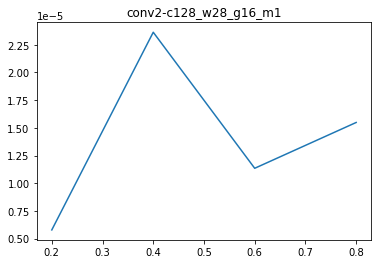

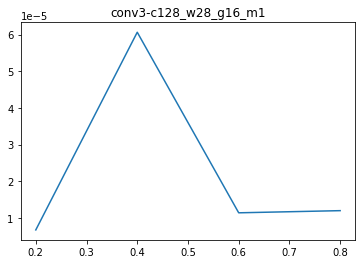

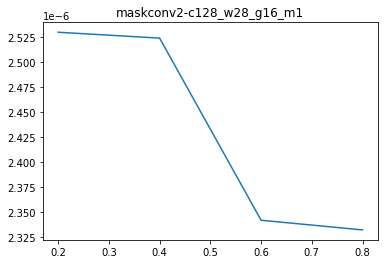

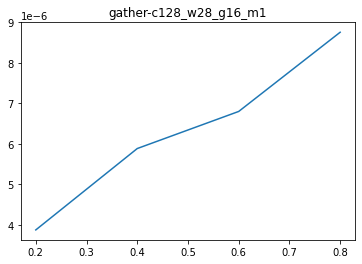

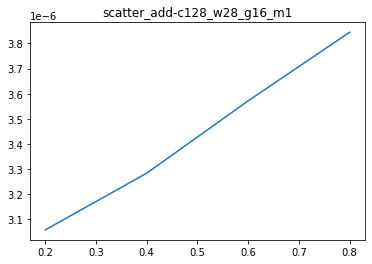

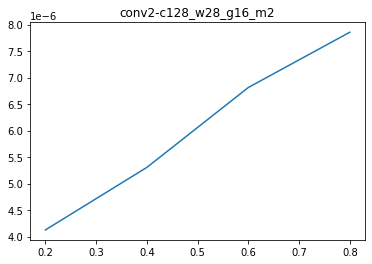

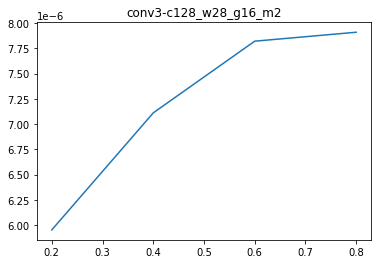

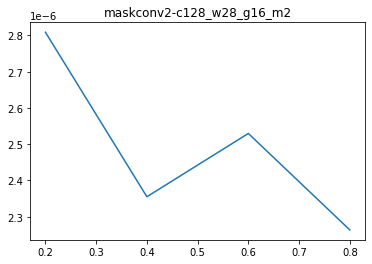

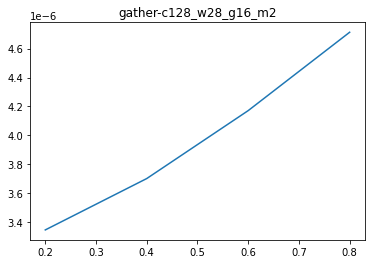

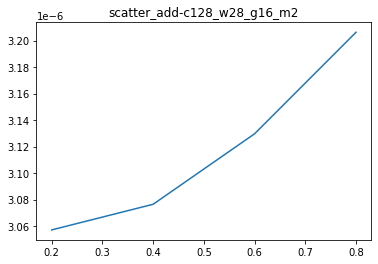

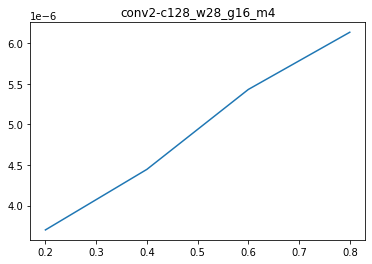

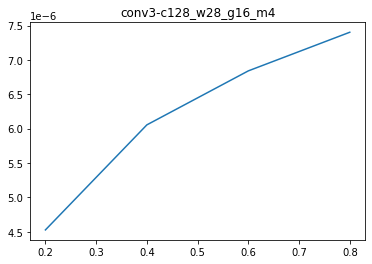

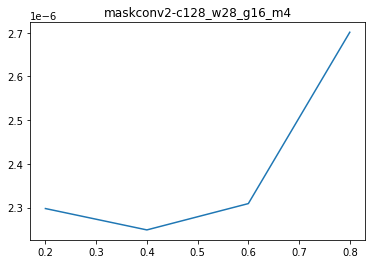

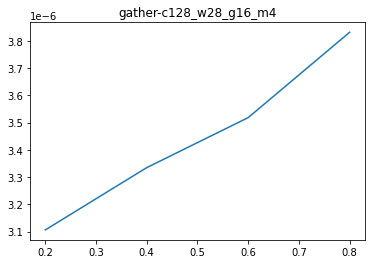

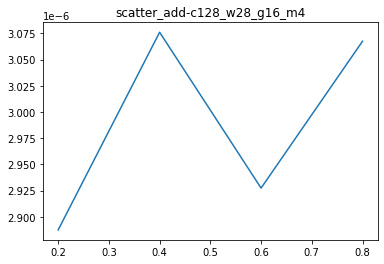

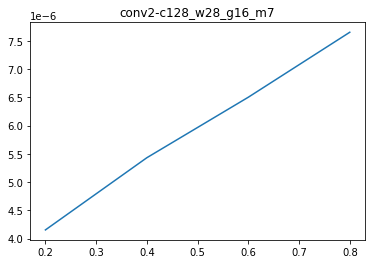

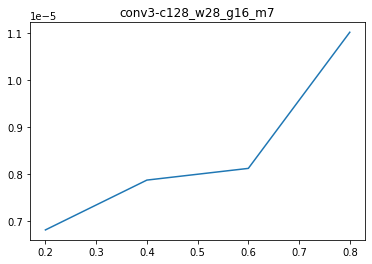

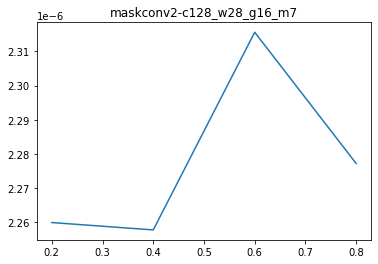

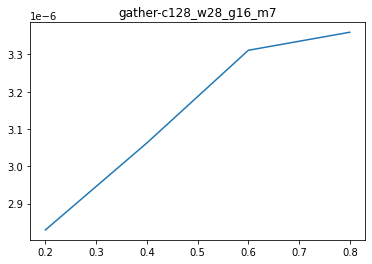

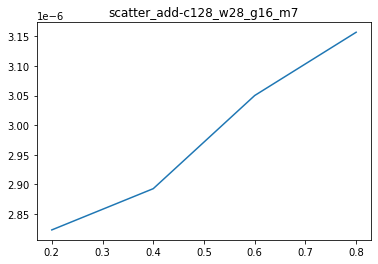

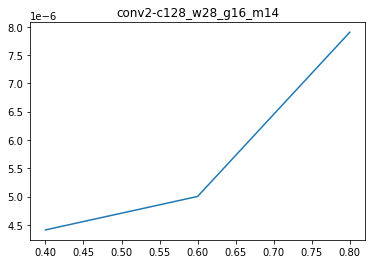

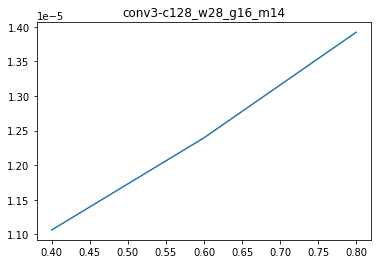

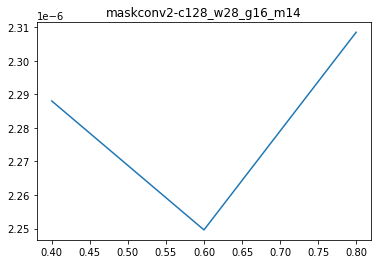

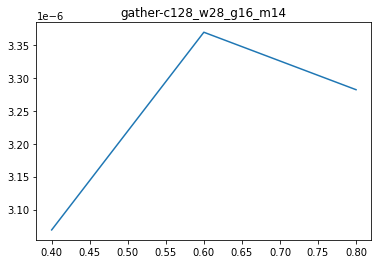

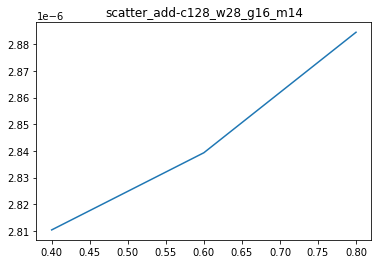

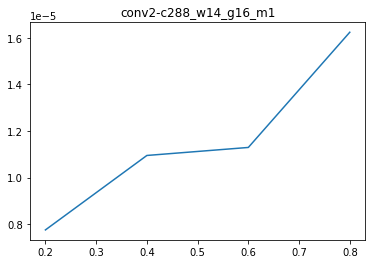

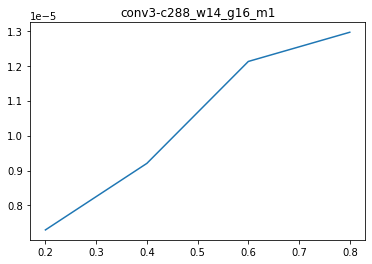

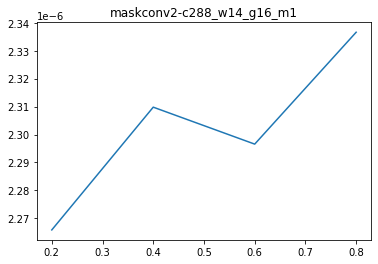

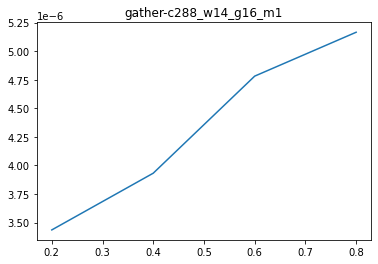

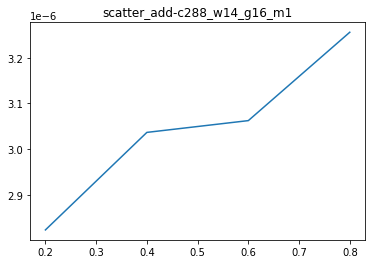

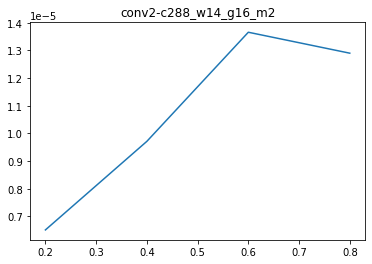

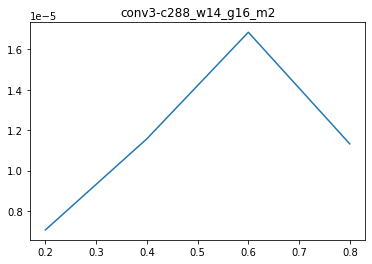

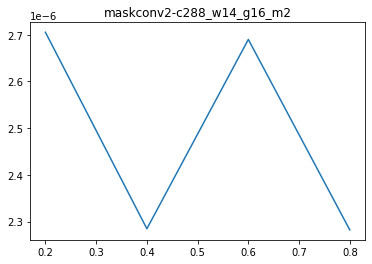

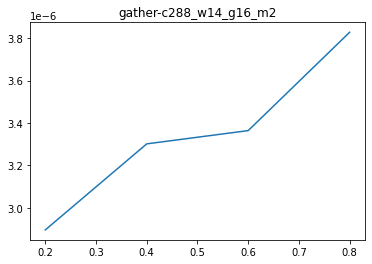

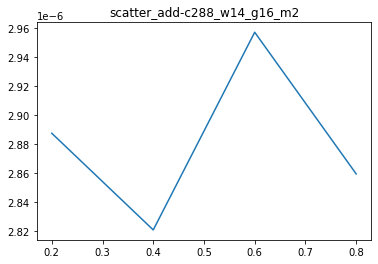

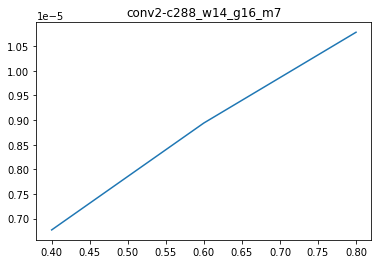

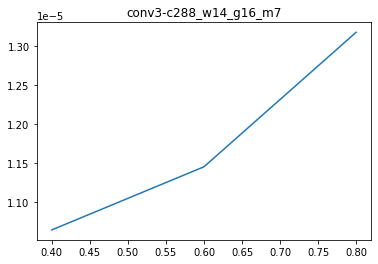

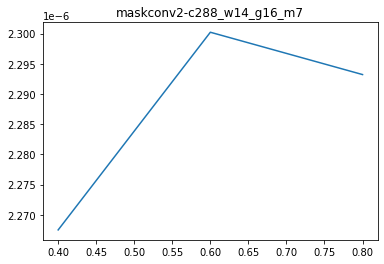

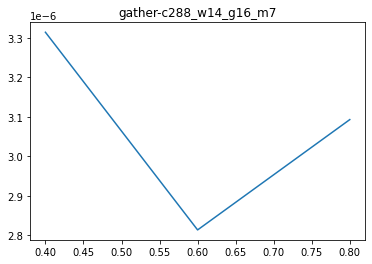

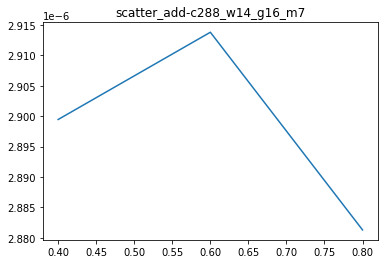

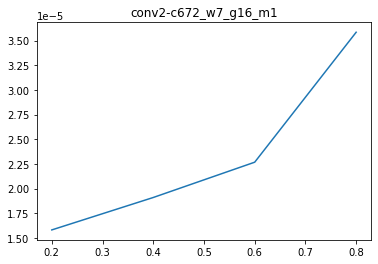

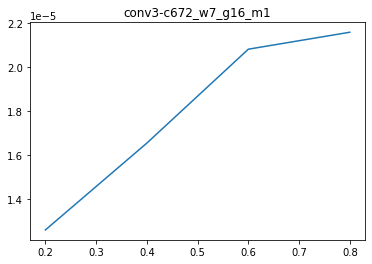

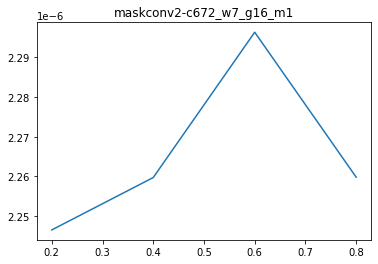

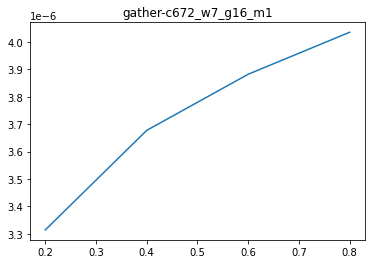

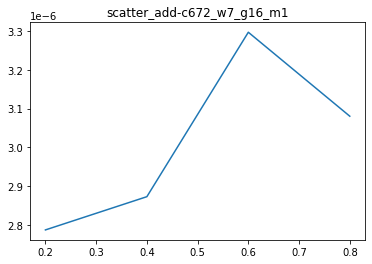

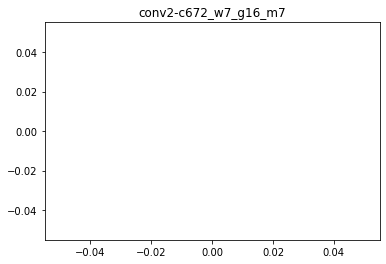

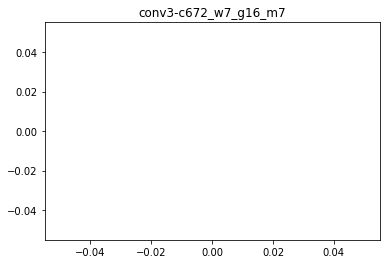

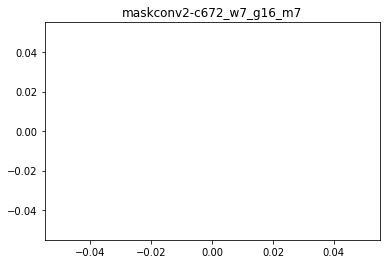

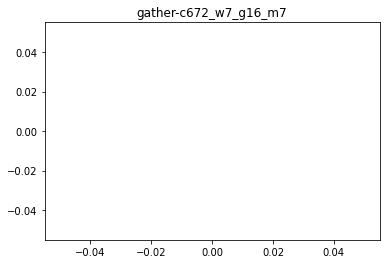

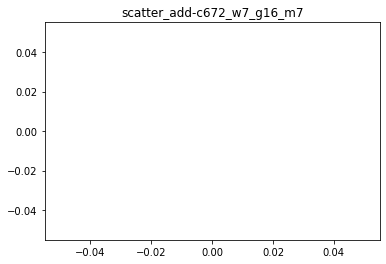

In [6]:
import matplotlib.pyplot as plt

def plot_s_perf(channel, width, group, granularity, module):
    x, y = [], []
    for r in rr:
        if r["channel"] != channel or r["width"] != width or r["group"] != group: continue
        if r["granularity"] != granularity: continue
        x.append(r["sparsity"])
        y.append(r[module])
    plt.plot(x, y)
    plt.title(f"{module}-c{channel}_w{width}_g{group}_m{granularity}")
    plt.show()

channels, group = regnet_parameters("008")
for i in range(4):
    channel = channels[i]
    width = widths[i]
    for g in get_factors(width):
        for module in ["conv2", "conv3", "maskconv2", "gather", "scatter_add"]:
            plot_s_perf(channel, width, group, g, module)
            

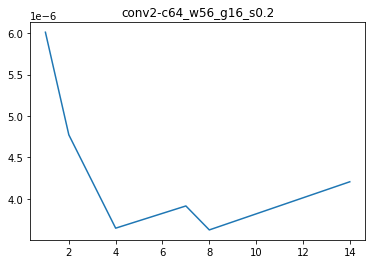

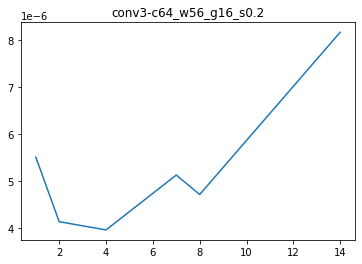

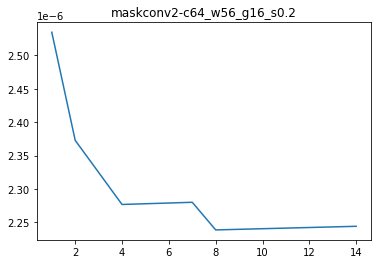

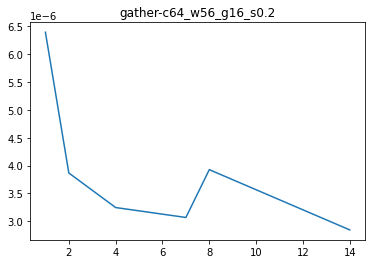

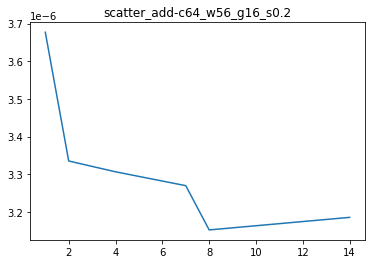

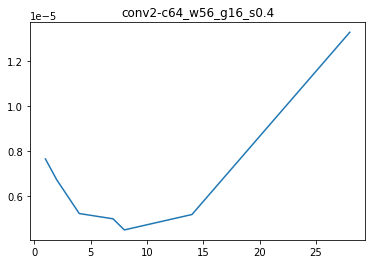

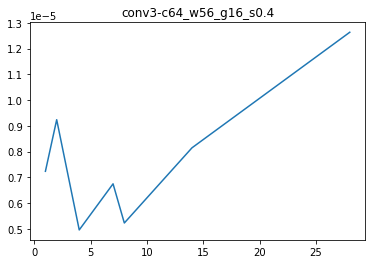

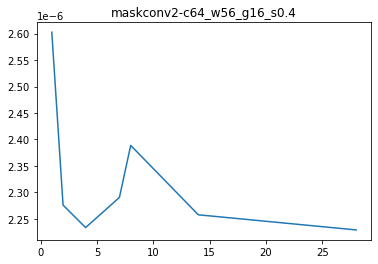

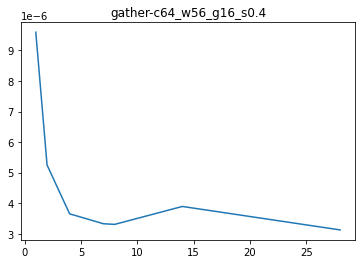

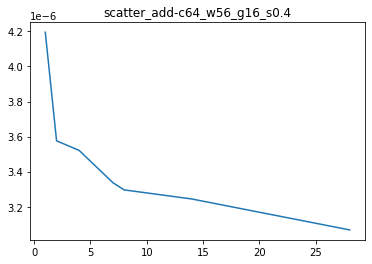

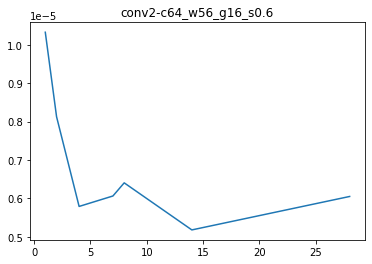

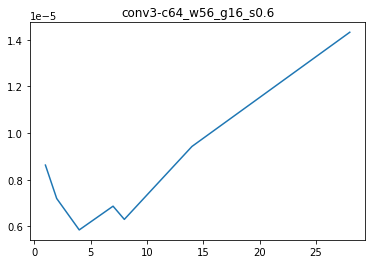

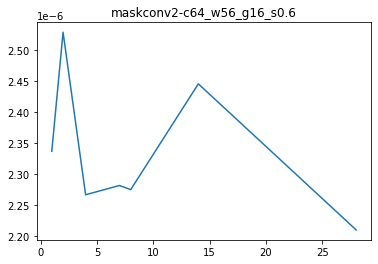

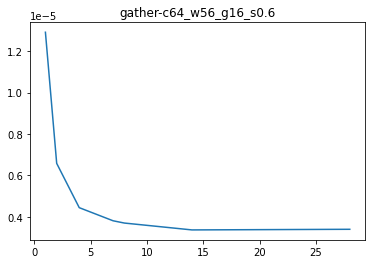

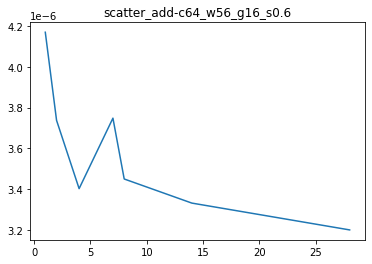

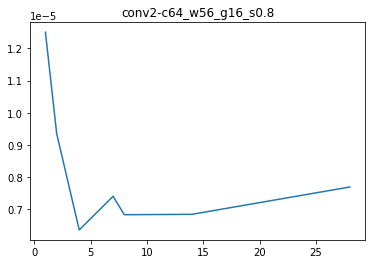

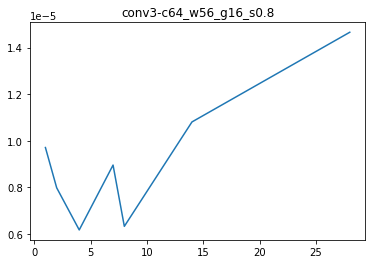

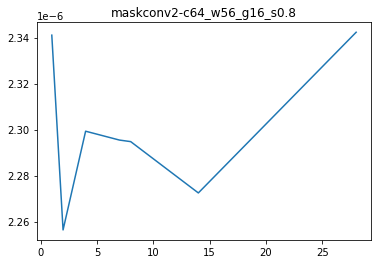

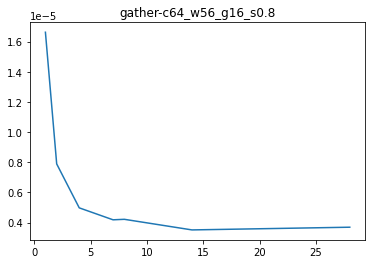

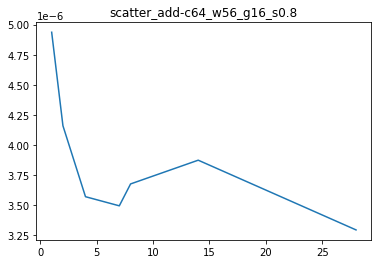

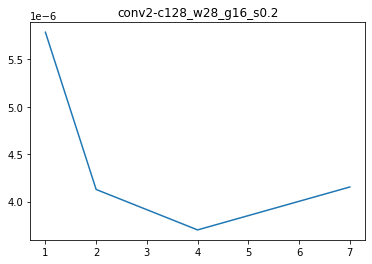

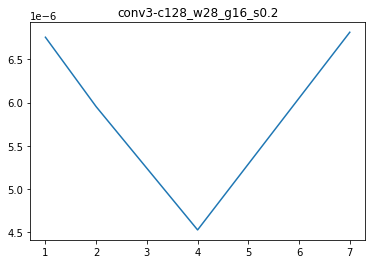

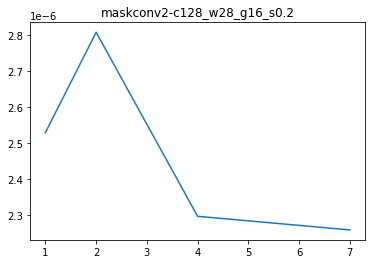

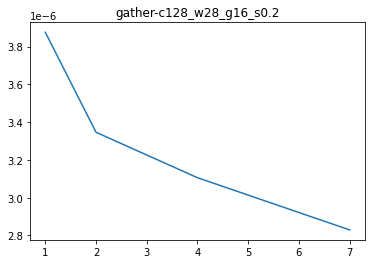

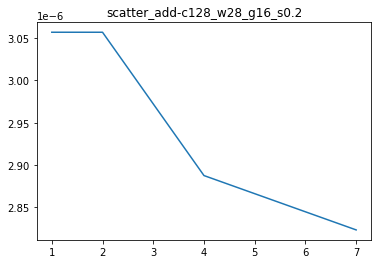

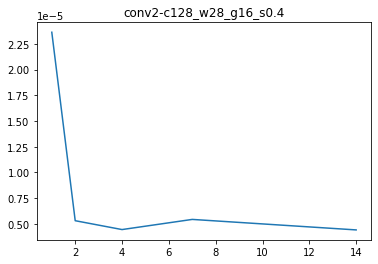

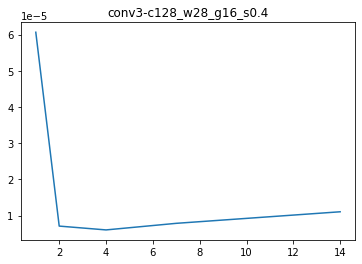

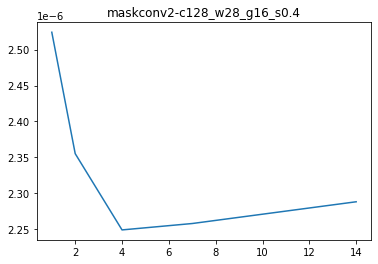

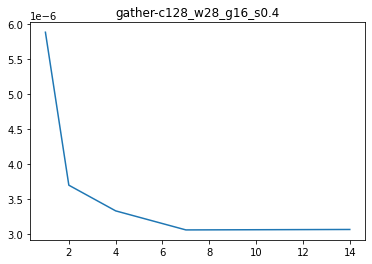

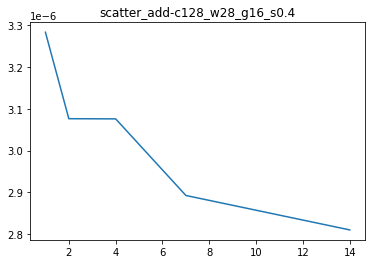

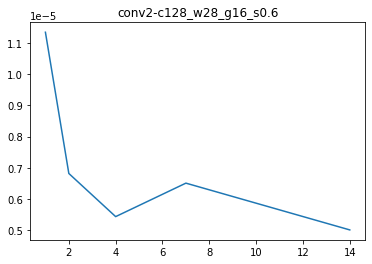

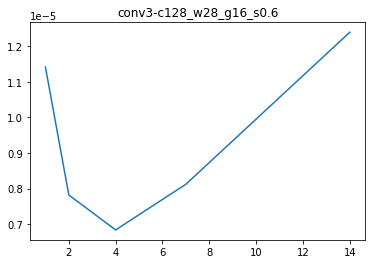

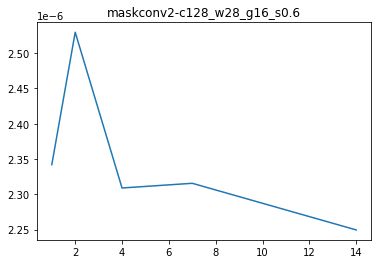

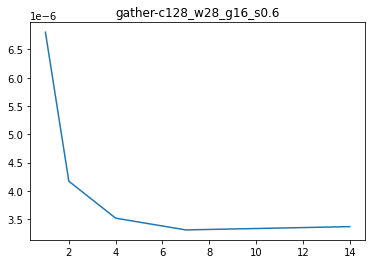

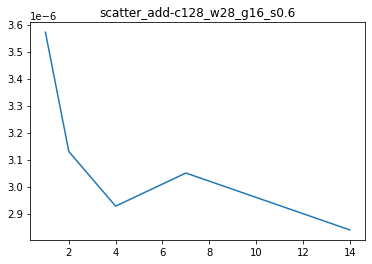

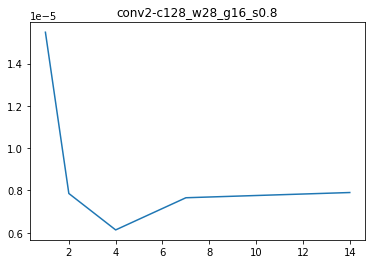

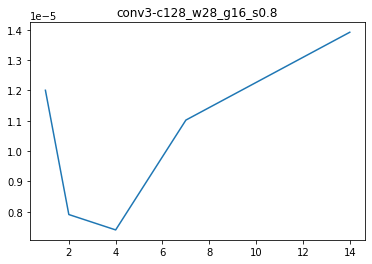

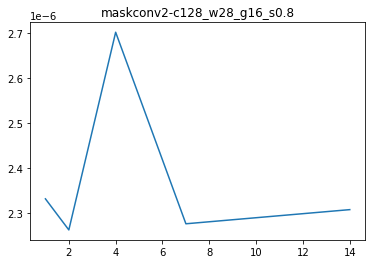

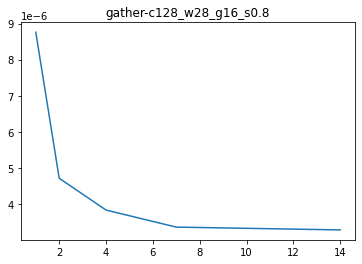

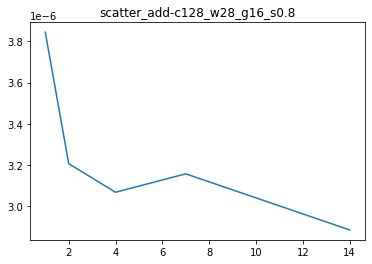

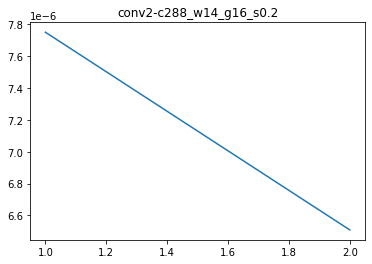

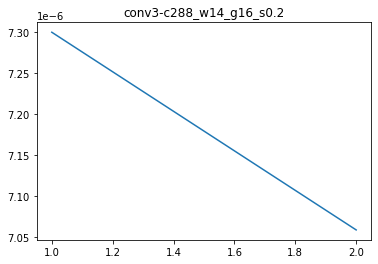

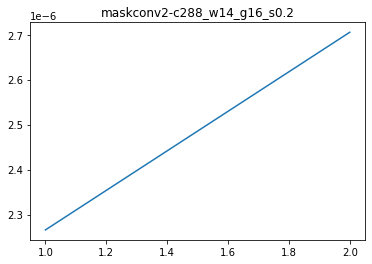

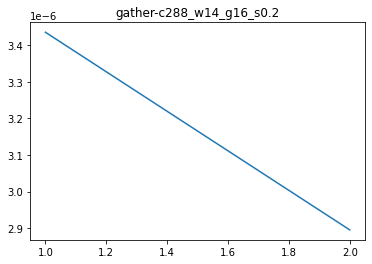

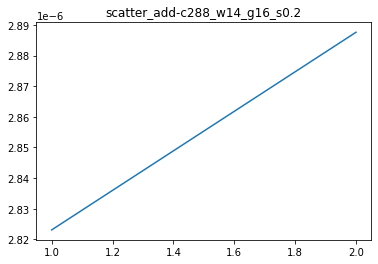

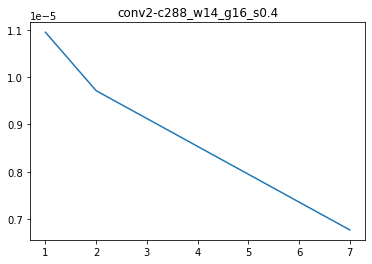

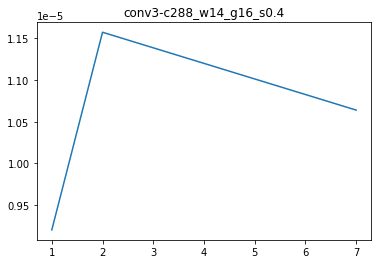

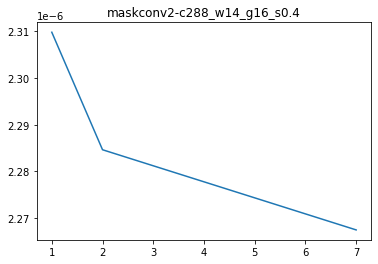

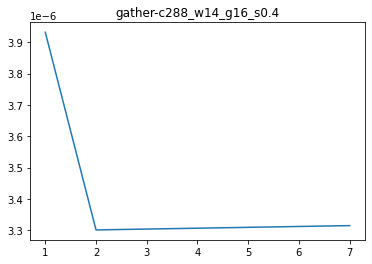

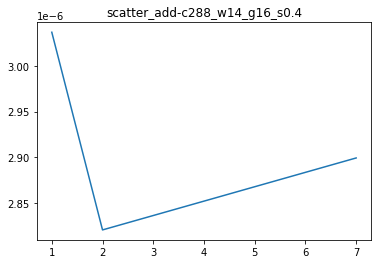

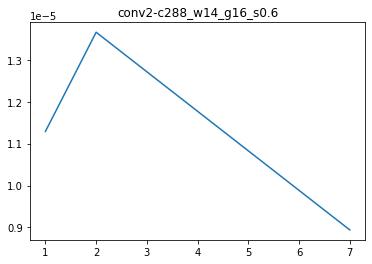

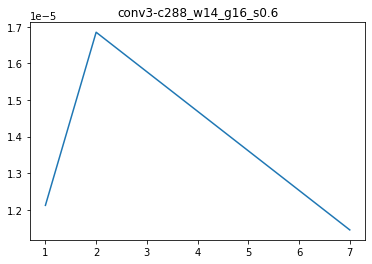

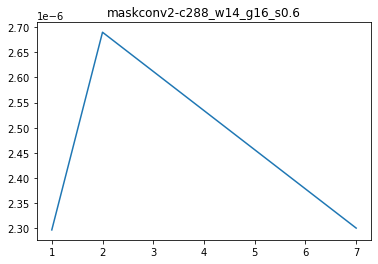

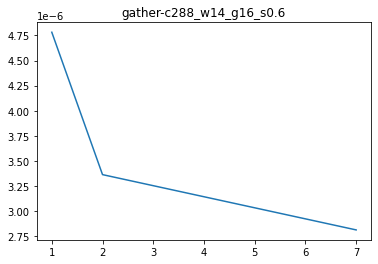

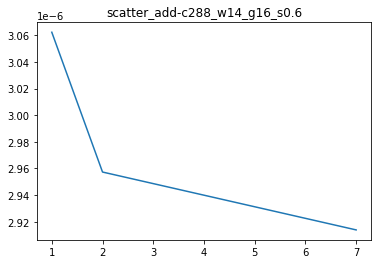

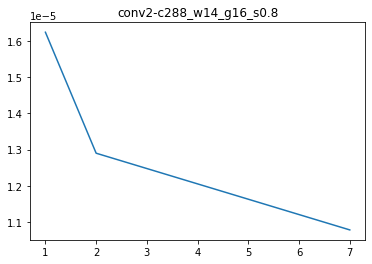

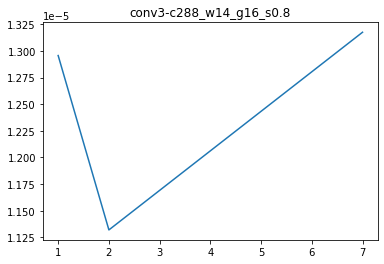

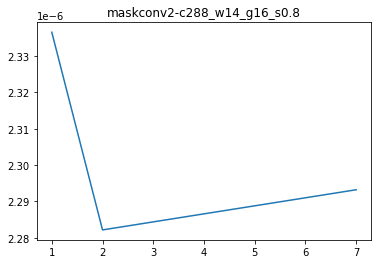

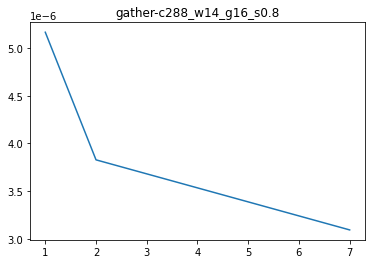

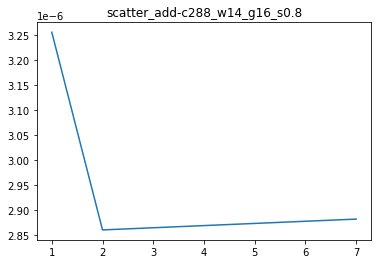

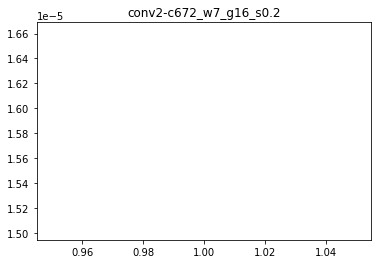

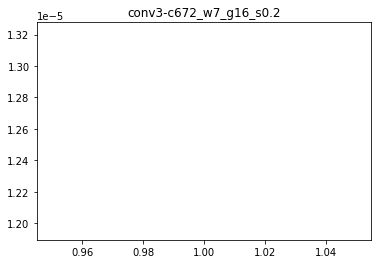

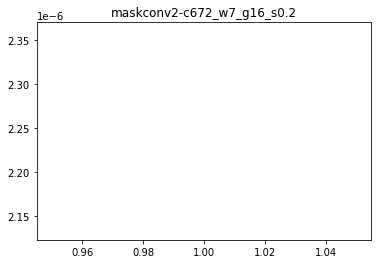

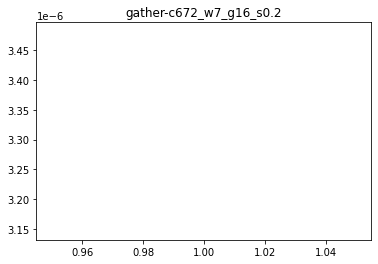

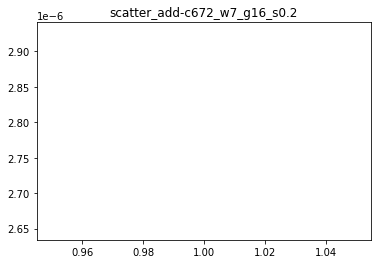

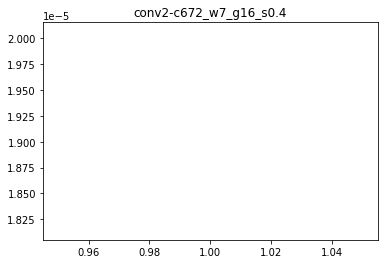

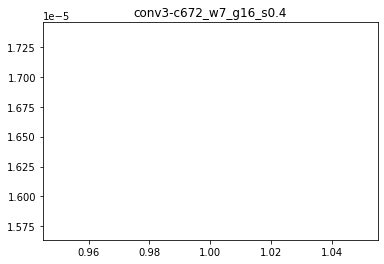

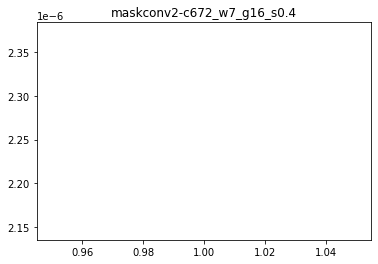

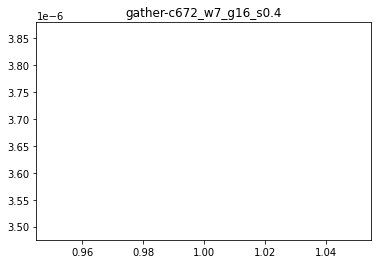

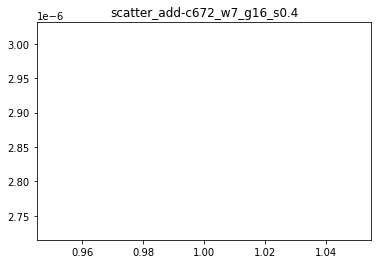

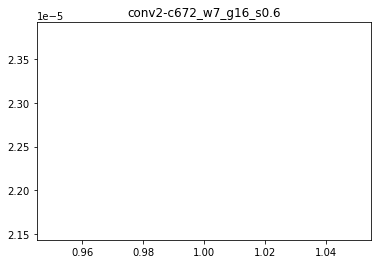

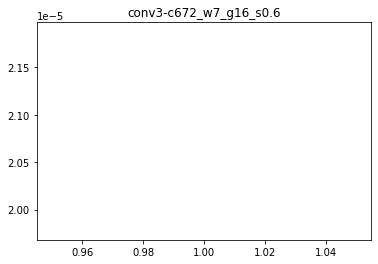

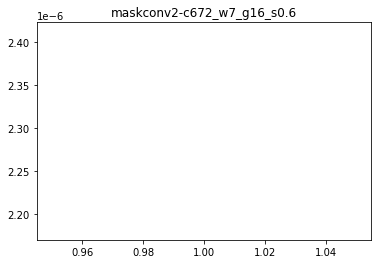

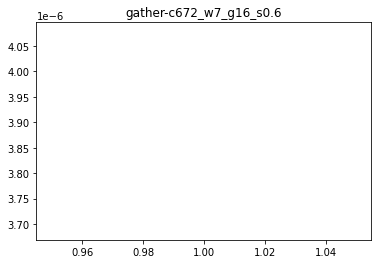

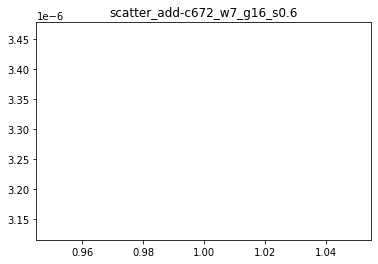

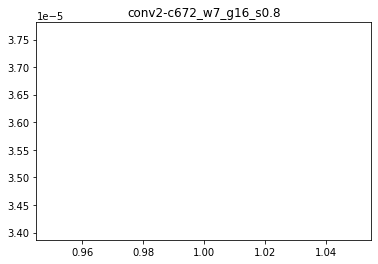

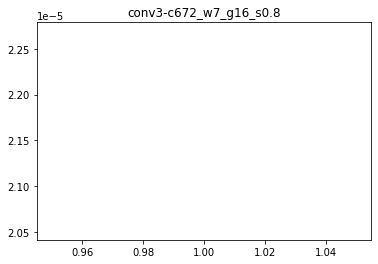

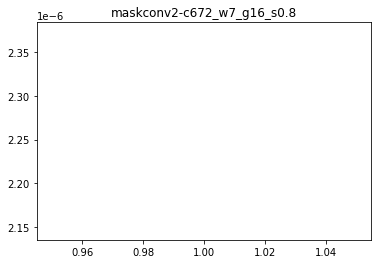

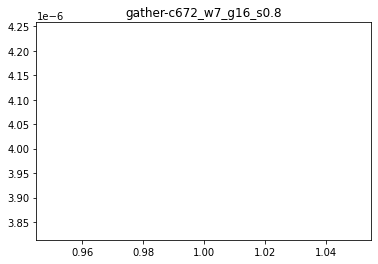

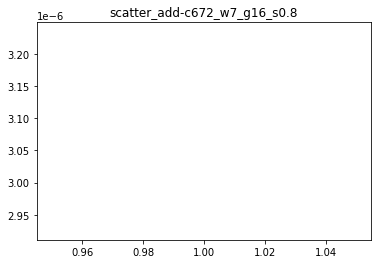

In [7]:
import matplotlib.pyplot as plt

def plot_g_perf(channel, width, group, sparsity, module):
    x, y = [], []
    for r in rr:
        if r["channel"] != channel or r["width"] != width or r["group"] != group: continue
        if r["sparsity"] != sparsity: continue
        x.append(r["granularity"])
        y.append(r[module])
    plt.plot(x, y)
    plt.title(f"{module}-c{channel}_w{width}_g{group}_s{sparsity}")
    plt.show()

channels, group = regnet_parameters("008")
ss = [0.2, 0.4, 0.6, 0.8]
for i in range(4):
    channel = channels[i]
    width = widths[i]
    for s in ss:
        for module in ["conv2", "conv3", "maskconv2", "gather", "scatter_add"]:
            plot_g_perf(channel, width, group, s, module)
            
        